# Virial Mass Estimation of Galaxy Cluster ACO 2670
**Author:** Jackson Ferguson  
**Data Source:** SDSS DR18  
**Objective:** To estimate the virial mass and mass-to-light ratio of ACO 2670 by isolating cluster members via an iterative clipping algorithm and analyzing kinematic data.

**Key Libraries:** `astropy`, `scipy`, `numpy`, `pandas`, `sklearn`

## Data Retrieval

To analyze the ACO 2670 galaxy cluster, photometric and spectroscopic data were retrieved from the Sloan Digital Sky Survey (SDSS) Data Release 18 (DR18). The dataset included the positions, magnitudes, extinction corrections, and redshifts of galaxies in a 2 Mpc region centered on the cluster. The SQL query used for data retrieval applied spatial and redshift constraints to ensure that the sample included only galaxies near the cluster while filtering out foreground and background objects. The initial member selection used a 3σ clipping method, retaining galaxies within three standard deviations of the mean redshift.

https://skyserver.sdss.org/dr18/SearchTools/sql

```sql
SELECT 
    p.objID,               
    p.ra,                  
    p.dec,                 
    p.r,                   
    p.psfMagErr_r AS rErr, 
    p.extinction_r,        
    s.z,                   
    s.zErr                 
FROM 
    PhotoObj AS p          
JOIN 
    SpecObj AS s           
ON 
    p.objID = s.bestObjID  
WHERE 
    p.ra BETWEEN 358.19 AND 358.89  
    AND p.dec BETWEEN -10.76 AND -10.06  
    AND s.z BETWEEN 0.024 AND 0.124  
    AND s.class = 'GALAXY'  
    AND p.type = 3  -- 3 corresponds to 'GALAXY' in PhotoObj.type
    AND s.z IS NOT NULL  
    AND s.class IS NOT NULL

## 1. Environment Setup
We utilize `astropy` for cosmological calculations, `scipy`/`sklearn` for statistical modeling, and `matplotlib` for visualization.

In [18]:
# Constants
from astropy import constants as const
from astropy import units as u

# Data Manipulation and Math
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Statistical Modeling
from scipy import stats
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from astropy.stats import biweight_midvariance
from sklearn.mixture import GaussianMixture

# Cosmology
from astropy.cosmology import FlatLambdaCDM

# Set visual style for plots
plt.style.use("seaborn-v0_8-whitegrid")

## 2. Configuration
Defining the cosmological framework (Planck 2018 parameters) and physical constants used throughout the analysis.

**Note:** Physical constants are sourced from `astropy.constants` for maximum precision.

In [19]:
# -----------------------------------------------------------------------------
# 1. Cosmological Parameters (Planck 2018/2020)
# -----------------------------------------------------------------------------
H0 = 67.8  # Hubble constant (km/s/Mpc)
H0_ERR = 0.46  # Uncertainty in Hubble constant
OMEGA_M = 0.3089  # Matter density parameter
COSMO = FlatLambdaCDM(H0=H0, Om0=OMEGA_M)

# -----------------------------------------------------------------------------
# 2. Physical Constants (Derived from Astropy)
# -----------------------------------------------------------------------------
# Speed of light: Convert m/s -> km/s
C_LIGHT = const.c.to("km/s").value

# Gravitational Constant: m^3 kg^-1 s^-2
G = const.G.value

# Solar Mass: kg
M_SUN_KG = const.M_sun.value

# Distance Conversions
MPC_TO_M = (1 * u.Mpc).to("m").value
KM_TO_M = 1e3

# -----------------------------------------------------------------------------
# 3. Analysis Parameters
# -----------------------------------------------------------------------------
CLUSTER_SELECTION_RADIUS_MPC = 1.5
GMM_RANDOM_STATE = 42
VELOCITY_BIN_WIDTH = 200

print(f"Speed of Light (km/s): {C_LIGHT:.3f}")
print(f"Gravitational Constant: {G:.3e}")
print(f"Solar Mass (kg):        {M_SUN_KG:.3e}")
print(f"Mpc to Meters:          {MPC_TO_M:.3e}")

Speed of Light (km/s): 299792.458
Gravitational Constant: 6.674e-11
Solar Mass (kg):        1.988e+30
Mpc to Meters:          3.086e+22


## 3. Helper Functions
Core algorithms for data processing, statistical modeling, and visualization.

In [20]:
def load_galaxy_data(filepath: str) -> pd.DataFrame:
    """
    Loads galaxy cluster data from a CSV file.

    Parameters
    ----------
    filepath : str
        Path to the CSV file relative to the notebook.

    Returns
    -------
    pd.DataFrame
        DataFrame containing galaxy catalog. Returns empty DF on failure.
    """
    try:
        # Read CSV, handling comment lines
        df = pd.read_csv(filepath, comment="#")
        print(f"[INFO] Successfully loaded {len(df)} galaxy records.")
        return df
    except FileNotFoundError:
        print(f"[ERROR] File not found at: {filepath}")
        return pd.DataFrame()


def plot_sky_distribution(ra_data, dec_data, title="Galaxy Distribution"):
    """
    Plots the 2D spatial distribution of galaxies.

    Parameters
    ----------
    ra_data : array-like
        Right Ascension coordinates.
    dec_data : array-like
        Declination coordinates.
    title : str
        Plot title.
    """
    plt.figure(figsize=(8, 8))

    # Plot galaxy positions
    plt.scatter(ra_data, dec_data, color="crimson", s=15, alpha=0.7, label="Galaxies")

    # Styling
    plt.xlabel("Right Ascension (deg)", fontsize=12)
    plt.ylabel("Declination (deg)", fontsize=12)
    plt.title(title, fontsize=14, fontweight="bold")
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    plt.axis("equal")  # Ensure spatial scales are consistent

    plt.tight_layout()
    plt.show()


def compute_cluster_center(df: pd.DataFrame) -> tuple[float, float, float, float]:
    """
    Computes the weighted mean RA and Dec of the cluster using inverse-variance weighting.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing member galaxies with columns 'ra', 'dec', and 'rErr'.

    Returns
    -------
    tuple[float, float, float, float]
        weighted_ra, weighted_dec, ra_uncertainty, dec_uncertainty
    """
    # Weights = Inverse Variance (1 / sigma^2)
    weights = 1 / (df["rErr"] ** 2)

    # Calculate weighted means
    w_ra = np.average(df["ra"], weights=weights)
    w_dec = np.average(df["dec"], weights=weights)

    # Calculate weighted variance with Bessel's correction (N / N-1)
    # This provides an unbiased estimator of the sample variance
    N = len(df)
    bias_factor = N / (N - 1)

    # Weighted Sample Variance = (Sum(w * (x - mu)^2) / Sum(w)) * (N / N-1)
    var_ra = np.average((df["ra"] - w_ra) ** 2, weights=weights) * bias_factor
    var_dec = np.average((df["dec"] - w_dec) ** 2, weights=weights) * bias_factor

    # Standard Error of the Weighted Mean
    ra_unc = np.sqrt(var_ra / np.sum(weights))
    dec_unc = np.sqrt(var_dec / np.sum(weights))

    return w_ra, w_dec, ra_unc, dec_unc


def gaussian_func(x: np.ndarray, amp: float, mean: float, std: float) -> np.ndarray:
    """Standard Gaussian function for curve fitting."""
    return amp * np.exp(-0.5 * ((x - mean) / std) ** 2)


def compute_redshift_distribution(
    df: pd.DataFrame, weight_threshold: float = 0.2
) -> tuple:
    """
    Models the redshift distribution to determine cluster $z$ and velocity dispersion.

    Uses the Bayesian Information Criterion (BIC) to choose between a single
    Gaussian model and a Gaussian Mixture Model (GMM).

    Parameters
    ----------
    df : pd.DataFrame
        Galaxy data containing 'z' (redshift) and 'zErr' (error).
    weight_threshold : float
        Minimum component weight required to accept a GMM fit as valid.

    Returns
    -------
    tuple
        (cluster_z, cluster_z_std, bin_edges, popt, gmm, model_name, bic_single, bic_gmm)
    """
    redshifts = df["z"].values
    z_errors = df["zErr"].values

    # 1. Optimal Binning (Freedman-Diaconis Rule)
    # Minimizes the integrated squared error of the histogram
    q75, q25 = np.percentile(redshifts, [75, 25])
    iqr = q75 - q25

    # Robust bin width calculation
    bin_width_iqr = 2 * iqr / (len(redshifts)) ** (1 / 3)
    bin_width_std = 3.5 * np.std(redshifts) / (len(redshifts)) ** (1 / 3)
    bin_width = max(bin_width_iqr, bin_width_std)

    n_bins = max(int(np.ceil((redshifts.max() - redshifts.min()) / bin_width)), 10)

    # 2. Histogram Generation
    hist, bin_edges = np.histogram(redshifts, bins=n_bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # 3. Weighted Statistics for Initial Guesses
    weights = 1 / (z_errors**2)
    w_mean = np.average(redshifts, weights=weights)
    w_std = np.sqrt(np.average((redshifts - w_mean) ** 2, weights=weights))

    # 4. Single Gaussian Fit (Curve Fit)
    # Weight bins by 1/sqrt(N) to account for Poisson counting statistics
    hist_errors = np.sqrt(hist)
    hist_errors[hist_errors == 0] = 1

    popt, _ = curve_fit(
        gaussian_func,
        bin_centers,
        hist,
        p0=[max(hist), w_mean, w_std],
        sigma=1 / hist_errors,
    )

    # 5. Gaussian Mixture Model (GMM) Fit
    X = redshifts.reshape(-1, 1)
    gmm = GaussianMixture(n_components=2, random_state=GMM_RANDOM_STATE).fit(X)

    # 6. Model Selection (BIC)
    # Calculate BIC manually for Single Gaussian (k=3 parameters: amp, mean, std)
    log_likelihood_single = np.sum(np.log(gaussian_func(redshifts, *popt)))
    bic_single = 3 * np.log(len(redshifts)) - 2 * log_likelihood_single

    bic_gmm = gmm.bic(X)
    gmm_weights = gmm.weights_

    # Select best model based on BIC and component significance
    if bic_gmm < bic_single and np.all(gmm_weights > weight_threshold):
        model_name = "Mixture of Gaussians"
        # Use the dominant component for cluster properties
        main_comp_idx = np.argmax(gmm_weights)
        cluster_z = gmm.means_[main_comp_idx, 0]
        cluster_z_std = np.sqrt(gmm.covariances_[main_comp_idx, 0, 0])
    else:
        model_name = "Single Gaussian"
        cluster_z, cluster_z_std = popt[1], popt[2]

    return (
        cluster_z,
        cluster_z_std,
        bin_edges,
        popt,
        gmm,
        model_name,
        bic_single,
        bic_gmm,
    )


def plot_redshift_fit(z, bins, popt, gmm, model, z_c, z_s, bic_s, bic_g):
    plt.figure(figsize=(10, 6))

    # 1. Data Histogram
    plt.hist(
        z,
        bins=bins,
        density=True,
        color="skyblue",
        alpha=0.6,
        edgecolor="white",
        label="Data",
    )

    # Evaluation Grid
    x = np.linspace(min(z), max(z), 1000)

    # 2. Single Gaussian Model
    plt.plot(
        x,
        gaussian_func(x, *popt),
        color="crimson",
        linewidth=2,
        label="Single Gaussian",
    )

    # 3. GMM Model (Total Density)
    # We use score_samples which returns log-density
    log_density = gmm.score_samples(x.reshape(-1, 1))
    plt.plot(
        x,
        np.exp(log_density),
        color="darkgreen",
        linewidth=2,
        linestyle="--",
        label="GMM (Total)",
    )

    # 4. GMM Components (The part you wanted back!)
    for i in range(gmm.n_components):
        mean = gmm.means_[i, 0]
        std = np.sqrt(gmm.covariances_[i, 0, 0])
        weight = gmm.weights_[i]

        # Calculate individual component density
        component_pdf = weight * stats.norm.pdf(x, mean, std)

        plt.plot(
            x,
            component_pdf,
            color="green",
            linestyle=":",
            alpha=0.6,
            label=f"GMM Comp {i + 1} (w={weight:.2f})",
        )

    # Annotations
    info_text = (
        f"Selected: {model}\n"
        f"$\\mu_z = {z_c:.4f}$\n"
        f"$\\sigma_z = {z_s:.4f}$\n"
        f"BIC (Single): {bic_s:.1f}\n"
        f"BIC (GMM): {bic_g:.1f}"
    )
    plt.text(
        0.02,
        0.98,
        info_text,
        transform=plt.gca().transAxes,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.9),
    )

    plt.xlabel("Redshift ($z$)", fontsize=12)
    plt.ylabel("Probability Density", fontsize=12)
    plt.title("Redshift Distribution & Model Selection", fontsize=14)
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    plt.show()


def compute_cluster_distance(
    z: float, z_err: float
) -> tuple[float, float, float, float]:
    """
    Calculates the Luminosity Distance and Relativistic Recession Velocity.

    Parameters
    ----------
    z : float
        Cluster mean redshift.
    z_err : float
        Uncertainty in cluster redshift.

    Returns
    -------
    tuple
        (distance_Mpc, distance_err_Mpc, v_rec_kms, v_rec_err_kms)
    """
    # 1. Relativistic Recession Velocity
    # Formula: v = c * ((1+z)^2 - 1) / ((1+z)^2 + 1)
    z_plus_1_sq = (1 + z) ** 2
    v_rec = C_LIGHT * (z_plus_1_sq - 1) / (z_plus_1_sq + 1)

    # Uncertainty in v_rec (analytical derivative)
    # dv/dz = c * 4(1+z) / ((1+z)^2 + 1)^2
    dv_dz = C_LIGHT * 4 * (1 + z) / ((z_plus_1_sq + 1) ** 2)
    v_rec_err = np.abs(dv_dz * z_err)

    # 2. Luminosity Distance (Mpc)
    dist_mpc = COSMO.luminosity_distance(z).value

    # Uncertainty in Distance
    # Part A: Contribution from redshift error (Numerical derivative)
    delta_z = z_err / 10.0
    d_plus = COSMO.luminosity_distance(z + delta_z).value
    d_minus = COSMO.luminosity_distance(z - delta_z).value
    dd_dz = (d_plus - d_minus) / (2 * delta_z)
    dist_err_z = np.abs(dd_dz * z_err)

    # Part B: Contribution from Hubble Constant error
    # Distance scales as 1/H0, so relative error adds linearly
    dist_err_h0 = dist_mpc * (H0_ERR / H0)

    # Total Error (Quadrature sum)
    dist_err_total = np.sqrt(dist_err_z**2 + dist_err_h0**2)

    return dist_mpc, dist_err_total, v_rec, v_rec_err


def compute_projected_distances(
    df: pd.DataFrame, ra_center: float, dec_center: float, distance_metric_mpc: float
) -> pd.DataFrame:
    """
    Calculates projected physical distances from the cluster center.

    Parameters
    ----------
    df : pd.DataFrame
        Galaxy data with 'ra' and 'dec' columns (degrees).
    ra_center : float
        Cluster center RA (degrees).
    dec_center : float
        Cluster center Dec (degrees).
    distance_metric_mpc : float
        The angular diameter distance to the cluster in Mpc.

    Returns
    -------
    pd.DataFrame
        The input DataFrame with a new column 'proj_dist'.
    """
    # Convert inputs to radians
    ra_gal = np.radians(df["ra"])
    dec_gal = np.radians(df["dec"])
    ra_c = np.radians(ra_center)
    dec_c = np.radians(dec_center)

    # Small-Angle Approximation (Flat Sky)
    # Delta RA is scaled by cos(declination) to account for spherical geometry
    d_ra = (ra_gal - ra_c) * np.cos(dec_c)
    d_dec = dec_gal - dec_c

    # Angular separation (radians)
    theta_rad = np.sqrt(d_ra**2 + d_dec**2)

    # Physical distance (Mpc)
    df["proj_dist"] = theta_rad * distance_metric_mpc

    return df


def plot_radial_distribution(df: pd.DataFrame, selection_radius: float):
    """Plots the histogram of projected radial distances."""
    plt.figure(figsize=(10, 6))

    plt.hist(
        df["proj_dist"],
        bins=20,
        color="royalblue",
        alpha=0.7,
        edgecolor="black",
        label="Galaxy Density",
    )

    plt.axvline(
        selection_radius,
        color="crimson",
        linestyle="--",
        linewidth=2,
        label=f"Selection Cut ({selection_radius} Mpc)",
    )

    plt.xlabel("Projected Distance from Center (Mpc)", fontsize=12)
    plt.ylabel("Galaxy Count", fontsize=12)
    plt.title("Radial Distribution of Potential Members", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def apply_membership_cuts(
    df: pd.DataFrame,
    ra_c: float,
    dec_c: float,
    z_c: float,
    z_std: float,
    da_mpc: float,
    radius_mpc: float = 1.5,
    n_sigma: float = 3.0,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Filters galaxies based on radial distance and redshift dispersion.

    Parameters
    ----------
    df : pd.DataFrame
        Galaxy data.
    ra_c, dec_c : float
        Cluster center coordinates.
    z_c, z_std : float
        Cluster mean redshift and velocity dispersion (sigma).
    da_mpc : float
        Angular diameter distance to the cluster.
    radius_mpc : float
        Maximum projected radius for selection.
    n_sigma : float
        Sigma clipping threshold for redshift.

    Returns
    -------
    tuple
        (members_df, all_data_with_distances)
    """
    # 1. Recompute distances for the full dataset using the correct Da
    # (Ensures consistency if upstream variables changed)
    full_df = compute_projected_distances(df.copy(), ra_c, dec_c, da_mpc)

    # 2. Define Redshift Limits
    z_min = z_c - (n_sigma * z_std)
    z_max = z_c + (n_sigma * z_std)

    # 3. Apply Selections
    spatial_mask = full_df["proj_dist"] <= radius_mpc
    velocity_mask = (full_df["z"] >= z_min) & (full_df["z"] <= z_max)

    members = full_df[spatial_mask & velocity_mask].copy()

    print("Selection Criteria:")
    print(f"  - Radius <= {radius_mpc} Mpc")
    print(f"  - Redshift: {z_min:.4f} to {z_max:.4f} (+/- {n_sigma} sigma)")
    print(f"  - Selected {len(members)} members from {len(df)} candidates.")

    return members, full_df


def plot_member_selection(all_df, member_df, ra_c, dec_c, z_c, radius_mpc):
    """Visualizes the spatial selection of cluster members."""

    # Calculate angular radius (in degrees)
    da_mpc = COSMO.angular_diameter_distance(z_c).value
    theta_deg = np.degrees(radius_mpc / da_mpc)

    # --- CORRECTION FOR SPHERICAL PROJECTION ---
    # Because RA lines converge, a physical circle looks like an ellipse on an RA-Dec plot.
    # Width must be stretched by 1/cos(dec).
    cos_dec = np.cos(np.radians(dec_c))
    width_deg = 2 * theta_deg / cos_dec  # Stretch width
    height_deg = 2 * theta_deg  # Height stays the same
    # -------------------------------------------

    plt.figure(figsize=(8, 8))

    # Background: All galaxies
    plt.scatter(
        all_df["ra"],
        all_df["dec"],
        color="gray",
        alpha=0.4,
        s=15,
        label="Field Galaxies",
    )

    # Foreground: Members
    plt.scatter(
        member_df["ra"],
        member_df["dec"],
        color="crimson",
        alpha=0.8,
        s=20,
        label="Cluster Members",
    )

    # Selection Ellipse
    selection_patch = Ellipse(
        (ra_c, dec_c),
        width=width_deg,
        height=height_deg,
        color="black",
        fill=False,
        linestyle="--",
        linewidth=1.5,
        label=f"{radius_mpc} Mpc Limit",
    )
    plt.gca().add_patch(selection_patch)

    # Viewport formatting
    pad = theta_deg * 1.5
    plt.xlim(ra_c - pad, ra_c + pad)
    plt.ylim(dec_c - pad, dec_c + pad)
    plt.gca().set_aspect("equal")

    plt.xlabel("Right Ascension (deg)", fontsize=12)
    plt.ylabel("Declination (deg)", fontsize=12)
    plt.title("Cluster Membership Selection", fontsize=14)
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    plt.show()


def refine_cluster_properties(
    initial_members: pd.DataFrame,
    max_iterations: int = 10,
    tolerance: float = 1e-5,
    verbose: bool = True,
) -> tuple:
    """
    Iteratively refines cluster properties (centroid, redshift, membership).

    Parameters
    ----------
    initial_members : pd.DataFrame
        The DataFrame of candidate members from the initial selection.
    max_iterations : int
        Maximum number of refinement steps.
    tolerance : float
        Convergence threshold for parameters.
    verbose : bool
        If True, prints progress per iteration.

    Returns
    -------
    tuple
        (final_ra, final_dec, final_ra_err, final_dec_err,
         final_z, final_z_std, final_count, final_members_df)
    """
    members = initial_members.copy()

    # Initialize convergence trackers
    prev_ra, prev_dec, prev_z, prev_count = -1.0, -1.0, -1.0, -1

    for i in range(max_iterations):
        if verbose:
            print(f"--- Iteration {i + 1} ---")

        # 1. Update Centroid
        w_ra, w_dec, ra_err, dec_err = compute_cluster_center(members)

        # 2. Update Redshift Statistics
        # Note: We ignore the plotting/BIC outputs here, just need z and sigma
        z_c, z_std, *rest = compute_redshift_distribution(members)

        # 3. Update Distances
        # Physical size depends on z, so we must update Da every step
        da_mpc = COSMO.angular_diameter_distance(z_c).value

        # 4. Re-Evaluate Membership
        # Recalculate projected distances relative to NEW center
        members = compute_projected_distances(members, w_ra, w_dec, da_mpc)

        # Apply Sigma Clipping and Radius Cut
        z_min = z_c - (3 * z_std)
        z_max = z_c + (3 * z_std)

        # Filter the current set of members
        mask_spatial = members["proj_dist"] <= CLUSTER_SELECTION_RADIUS_MPC
        mask_velocity = (members["z"] >= z_min) & (members["z"] <= z_max)

        members = members[mask_spatial & mask_velocity].copy()
        current_count = len(members)

        if verbose:
            print(f"  Centroid: ({w_ra:.4f}, {w_dec:.4f})")
            print(f"  Redshift: {z_c:.5f} ± {z_std:.5f}")
            print(f"  Members:  {current_count}")

        # 5. Check Convergence
        # We check if the center, redshift, AND member count have stabilized
        params_changed = np.allclose(
            [prev_ra, prev_dec, prev_z], [w_ra, w_dec, z_c], atol=tolerance
        )
        if params_changed and (prev_count == current_count):
            if verbose:
                print(f"Convergence reached in {i + 1} iterations.\n")
            break

        # Update trackers for next loop
        prev_ra, prev_dec, prev_z, prev_count = w_ra, w_dec, z_c, current_count

    return w_ra, w_dec, ra_err, dec_err, z_c, z_std, current_count, members


def plot_final_spatial_distribution(
    all_data, member_data, center_ra, center_dec, z_cluster, radius_mpc
):
    """
    Plots the final spatial distribution of cluster members against the background field.
    """
    # Calculate angular radius (degrees)
    da_mpc = COSMO.angular_diameter_distance(z_cluster).value
    theta_deg = np.degrees(radius_mpc / da_mpc)

    # Correction for spherical projection
    # Width must be stretched by 1/cos(dec)
    cos_dec = np.cos(np.radians(center_dec))
    width_deg = 2 * theta_deg / cos_dec
    height_deg = 2 * theta_deg

    plt.figure(figsize=(8, 8))

    # Field Galaxies
    plt.scatter(
        all_data["ra"],
        all_data["dec"],
        color="gray",
        alpha=0.3,
        s=10,
        label="Field Galaxies",
    )

    # Cluster Members
    plt.scatter(
        member_data["ra"],
        member_data["dec"],
        color="crimson",
        alpha=0.8,
        s=15,
        label="Final Members",
    )

    # 1.5 Mpc Limit (Ellipse)
    selection_patch = Ellipse(
        (center_ra, center_dec),
        width=width_deg,
        height=height_deg,
        color="black",
        fill=False,
        linestyle="--",
        linewidth=1.5,
        label=f"{radius_mpc} Mpc Limit",
    )
    plt.gca().add_patch(selection_patch)

    # Formatting
    pad = theta_deg * 1.2
    plt.xlim(center_ra - pad, center_ra + pad)
    plt.ylim(center_dec - pad, center_dec + pad)
    plt.gca().set_aspect("equal")

    plt.xlabel("Right Ascension (deg)", fontsize=12)
    plt.ylabel("Declination (deg)", fontsize=12)
    plt.title(
        f"Final Configuration: ACO 2670 (N={len(member_data)})",
        fontsize=14,
        fontweight="bold",
    )
    plt.legend(loc="upper right", frameon=True)
    plt.grid(True, alpha=0.3)
    plt.show()


def compute_absolute_magnitudes(
    df: pd.DataFrame, d_lum_mpc: float, d_lum_err_mpc: float
) -> pd.DataFrame:
    """
    Computes absolute magnitudes (M_r) and propagates uncertainties.

    Parameters
    ----------
    df : pd.DataFrame
        Galaxy data with 'r' (magnitude), 'rErr', and 'extinction_r'.
    d_lum_mpc : float
        Luminosity distance to the cluster in Mpc.
    d_lum_err_mpc : float
        Uncertainty in luminosity distance.

    Returns
    -------
    pd.DataFrame
        The input dataframe with new columns 'M_r' and 'M_r_err'.
    """
    # Constants
    MPC_TO_PC = 1e6

    # Convert Distance to Parsecs
    d_pc = d_lum_mpc * MPC_TO_PC
    d_err_pc = d_lum_err_mpc * MPC_TO_PC

    # 1. Calculate Absolute Magnitude
    # M = m - A - 5*log10(d_pc) + 5
    df["M_r"] = df["r"] - df["extinction_r"] - 5 * np.log10(d_pc) + 5

    # 2. Error Propagation
    # sigma_M^2 = sigma_m^2 + (5 * sigma_d / (d * ln(10)))^2
    # Partial derivative w.r.t distance term
    dist_term_err = (5 * d_err_pc) / (d_pc * np.log(10))

    df["M_r_err"] = np.sqrt(df["rErr"] ** 2 + dist_term_err**2)

    return df


def plot_magnitude_distribution(df: pd.DataFrame):
    """Plots the distribution of absolute magnitudes."""
    plt.figure(figsize=(10, 6))

    # Histogram
    plt.hist(
        df["M_r"],
        bins=15,
        color="royalblue",
        alpha=0.7,
        edgecolor="black",
        label="Cluster Members",
    )

    # Annotations for Brightest/Faintest
    brightest = df["M_r"].min()
    faintest = df["M_r"].max()

    plt.axvline(
        brightest, color="crimson", linestyle="--", label=f"Brightest ({brightest:.2f})"
    )
    plt.axvline(
        faintest, color="navy", linestyle=":", label=f"Faintest ({faintest:.2f})"
    )

    plt.xlabel("Absolute $r$-band Magnitude ($M_r$)", fontsize=12)
    plt.ylabel("Number of Galaxies", fontsize=12)
    plt.title("Luminosity Function (Magnitude Distribution)", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.gca().invert_xaxis()  # Astronomical convention: brighter (negative) is left
    plt.show()


def compute_luminosities(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converts absolute magnitudes to solar luminosities (L_sun).

    Parameters
    ----------
    df : pd.DataFrame
        Galaxy data with 'M_r' and 'M_r_err'.

    Returns
    -------
    pd.DataFrame
        The input dataframe with new columns 'L_r' and 'L_r_err'.
    """
    # Solar absolute magnitude in SDSS r-band
    M_SUN_R = 4.76

    # 1. Calculate Luminosity
    # L = 10^(0.4 * (M_sun - M_gal))
    df["L_r"] = 10 ** (0.4 * (M_SUN_R - df["M_r"]))

    # 2. Error Propagation
    # sigma_L = L * (0.4 * ln(10) * sigma_M)
    # Derived from dL/dM = -0.4 * ln(10) * L
    ln_10 = np.log(10)
    df["L_r_err"] = df["L_r"] * (0.4 * ln_10 * df["M_r_err"])

    return df


def plot_luminosity_distribution(df: pd.DataFrame):
    """Plots the distribution of galaxy luminosities."""
    plt.figure(figsize=(10, 6))

    # Use log scale for luminosity if the range is large
    plt.hist(
        df["L_r"],
        bins=20,
        color="darkorange",
        alpha=0.7,
        edgecolor="black",
        label="Cluster Members",
    )

    plt.xlabel(r"Luminosity ($L_{\odot}$)", fontsize=12)
    plt.ylabel("Number of Galaxies", fontsize=12)
    plt.title("Distribution of Galaxy Luminosities", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Format x-axis to scientific notation
    plt.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))
    plt.show()


def compute_cumulative_luminosity(df: pd.DataFrame) -> tuple:
    """
    Computes the normalized cumulative luminosity profile.

    Parameters
    ----------
    df : pd.DataFrame
        Galaxy data with 'proj_dist' (Mpc), 'L_r', and 'L_r_err'.

    Returns
    -------
    tuple
        (r_sorted, cdf_norm, cdf_err, L_total, L_total_err)
    """
    # 1. Sort by radius
    df_sorted = df.sort_values(by="proj_dist").reset_index(drop=True)
    r_vals = df_sorted["proj_dist"].values

    # 2. Cumulative Sum
    # cumsum is sensitive to ordering, so sorting above is critical
    L_cum = np.cumsum(df_sorted["L_r"].values)

    # 3. Total Properties
    L_tot = df_sorted["L_r"].sum()
    # Quadrature sum of errors for the total
    L_tot_err = np.sqrt(np.sum(df_sorted["L_r_err"] ** 2))

    # 4. Normalize (CDF)
    cdf = L_cum / L_tot

    # 5. Error Propagation for CDF
    # Error in cumulative sum at index i
    L_cum_err = np.sqrt(np.cumsum(df_sorted["L_r_err"] ** 2))

    # Error in ratio (L_cum / L_tot)
    # Note: L_cum and L_tot are correlated, but we approximate for the plot bounds
    cdf_err = cdf * np.sqrt((L_cum_err / L_cum) ** 2 + (L_tot_err / L_tot) ** 2)

    return r_vals, cdf, cdf_err, L_tot, L_tot_err


def compute_effective_radius(
    r_vals: np.ndarray, cdf: np.ndarray, cdf_err: np.ndarray
) -> tuple:
    """
    Determines R_eff (where CDF=0.5) via linear interpolation.

    Returns
    -------
    tuple
        (R_eff, r_half, R_eff_err, r_half_err)
    """
    # Create interpolator: Radius as a function of Flux Fraction
    # We swap x and y (CDF vs Radius) to query for CDF=0.5
    radius_from_cdf = interp1d(cdf, r_vals, kind="linear", fill_value="extrapolate")

    # 1. Central Value
    r_eff_val = radius_from_cdf(0.5)

    # 2. Uncertainty Estimation: First-order Taylor Expansion
    # We propagate the vertical error in Flux (dF) to a horizontal error in Radius (dr).
    # dr = dF / |dF/dr| (where dF/dr is the local gradient of the CDF).

    # Estimate CDF error magnitude at the location of R_eff
    cdf_err_at_reff = float(interp1d(r_vals, cdf_err, kind="linear")(r_eff_val))

    # Calculate local gradient (dF/dr) near R_eff using central difference
    idx = np.argmin(np.abs(cdf - 0.5))

    # Guard against boundary indices
    if idx > 0 and idx < len(cdf) - 1:
        slope = (cdf[idx + 1] - cdf[idx - 1]) / (r_vals[idx + 1] - r_vals[idx - 1])
    else:
        # Fallback for edge cases (prevents division by zero, assumes linear approximation)
        slope = 1.0

    r_eff_unc = cdf_err_at_reff / slope

    # 3. Deprojection: 2D Projected R_eff -> 3D Half-light Radius (r_1/2)
    # The factor 4/3 is the geometric deprojection approximation derived by Wolf et al. (2010).
    # It holds true (< 2% error) for a wide range of spherical systems (Plummer, Exponential, etc.),
    # regardless of anisotropy.
    # Note: A pure Plummer sphere is ~1.305; Exponential is ~1.333.
    r_3d_val = (4 / 3) * r_eff_val
    r_3d_unc = (4 / 3) * r_eff_unc

    return r_eff_val, r_3d_val, r_eff_unc, r_3d_unc


def plot_cumulative_profile(r_vals, cdf, cdf_err, r_eff_val):
    """Visualizes the growth curve of cluster luminosity."""
    plt.figure(figsize=(10, 6))

    # Ensures operations like [-1] work even if inputs are pandas Series
    r_arr = np.array(r_vals)
    cdf_arr = np.array(cdf)
    err_arr = np.array(cdf_err)

    # We append the selection radius (1.5) to the x-axis
    # and repeat the final CDF value (1.0) to show the "flat top"
    r_plot = np.append(r_arr, CLUSTER_SELECTION_RADIUS_MPC)
    cdf_plot = np.append(cdf_arr, 1.0)

    # Assume error is constant in the empty region
    err_plot = np.append(err_arr, err_arr[-1])

    # Plot the padded curve
    plt.plot(
        r_plot,
        cdf_plot,
        color="navy",
        linewidth=2,
        label=r"Cumulative Luminosity $L(<r)$",
    )
    plt.fill_between(
        r_plot, cdf_plot - err_plot, cdf_plot + err_plot, color="blue", alpha=0.2
    )

    # 1. Structural Parameter (R_eff)
    plt.axhline(0.5, color="gray", linestyle=":", label="50% Total Light")
    plt.axvline(
        r_eff_val,
        color="crimson",
        linestyle="--",
        linewidth=1.5,
        label=r"$R_{eff}$ = " + f"{r_eff_val:.2f} Mpc",
    )

    # 2. Methodological Boundary (1.5 Mpc)
    plt.axvline(
        CLUSTER_SELECTION_RADIUS_MPC,
        color="black",
        linestyle="-.",
        alpha=0.6,
        label=f"Selection Cut ({CLUSTER_SELECTION_RADIUS_MPC} Mpc)",
    )

    plt.xlabel("Projected Distance (Mpc)", fontsize=12)
    plt.ylabel("Normalized Cumulative Luminosity", fontsize=12)
    plt.title("Cluster Luminosity Profile", fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    # Ensure the plot shows the full range up to the cut
    plt.xlim(0, CLUSTER_SELECTION_RADIUS_MPC * 1.05)
    plt.ylim(0, 1.05)
    plt.show()


def compute_peculiar_velocities(
    df: pd.DataFrame, z_cluster: float, z_cluster_err: float
) -> pd.DataFrame:
    """
    Calculates relativistic line-of-sight and peculiar velocities.

    Parameters
    ----------
    df : pd.DataFrame
        Galaxy data with 'z' and 'zErr'.
    z_cluster : float
        Mean cluster redshift.
    z_cluster_err : float
        Uncertainty in cluster redshift.

    Returns
    -------
    pd.DataFrame
        Input DataFrame with columns: 'v_los', 'v_los_err', 'v_pec', 'v_pec_err'.
    """
    # 1. Line-of-Sight Velocity (Relativistic)
    # v = c * ((1+z)^2 - 1) / ((1+z)^2 + 1)
    # Pre-calculate terms for efficiency
    z_gal_p1 = 1 + df["z"]
    df["v_los"] = C_LIGHT * (z_gal_p1**2 - 1) / (z_gal_p1**2 + 1)

    # Uncertainty in v_los
    # dv/dz = c * 4(1+z) / ((1+z)^2 + 1)^2
    dv_dz_gal = C_LIGHT * 4 * z_gal_p1 / ((z_gal_p1**2 + 1) ** 2)
    df["v_los_err"] = np.abs(dv_dz_gal * df["zErr"])

    # 2. Cluster Recessional Velocity
    z_cl_p1 = 1 + z_cluster
    v_cluster = C_LIGHT * (z_cl_p1**2 - 1) / (z_cl_p1**2 + 1)

    # Uncertainty in v_cluster
    dv_dz_cl = C_LIGHT * 4 * z_cl_p1 / ((z_cl_p1**2 + 1) ** 2)
    v_cluster_err = np.abs(dv_dz_cl * z_cluster_err)

    # 3. Peculiar Velocity (Rest Frame)
    # v_pec = (v_los - v_cluster) / (1 + z_cluster)
    # Note: The simple subtraction (v_los - v_cluster) is an approximation.
    # The relativistic denominator (1+z) is crucial for z ~ 0.08.
    df["v_pec"] = (df["v_los"] - v_cluster) / (1 + z_cluster)

    # Uncertainty Propagation
    # sigma_pec^2 = (sigma_v_los / (1+z))^2 + (sigma_v_cl / (1+z))^2
    # We assume errors are uncorrelated (which is true for individual galaxies vs mean)
    term1 = df["v_los_err"] / (1 + z_cluster)
    term2 = v_cluster_err / (1 + z_cluster)
    df["v_pec_err"] = np.sqrt(term1**2 + term2**2)

    return df


def measure_velocity_dispersion(v_data: np.ndarray) -> tuple:
    """
    Estimates velocity dispersion using Gaussian fitting and Biweight Midvariance.

    Returns
    -------
    tuple
        (sigma_gaussian, sigma_err, sigma_biweight)
    """
    # 1. Gaussian Fit
    # Binning
    bins = np.arange(
        v_data.min(), v_data.max() + VELOCITY_BIN_WIDTH, VELOCITY_BIN_WIDTH
    )
    hist, bin_edges = np.histogram(v_data, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Curve Fit
    # We reuse the gaussian_func defined in Step 6
    popt, pcov = curve_fit(
        gaussian_func,
        bin_centers,
        hist,
        p0=[max(hist), np.mean(v_data), np.std(v_data)],
    )

    sigma_gauss = np.abs(popt[2])
    sigma_err = np.sqrt(np.diag(pcov))[2]

    # 2. Biweight Midvariance (Robust)
    sigma_bi = np.sqrt(biweight_midvariance(v_data))

    return sigma_gauss, sigma_err, sigma_bi, popt


def test_multimodality(data: np.ndarray) -> bool:
    """
    Performs a basic check for multimodality using Kernel Density Estimation derivatives.
    Returns True if multiple peaks are detected.
    """
    kde = gaussian_kde(data)
    grid = np.linspace(min(data), max(data), 1000)
    pdf = kde(grid)

    # Count peaks (sign changes in derivative from + to -)
    derivative = np.diff(pdf)
    peaks = np.sum((derivative[:-1] > 0) & (derivative[1:] < 0))

    return peaks > 1


def plot_velocity_dispersion(v_data, popt, sigma_g, sigma_b):
    """Visualizes the peculiar velocity histogram and fits."""
    plt.figure(figsize=(10, 6))

    # Data
    plt.hist(
        v_data,
        bins=15,
        density=True,
        color="slateblue",
        alpha=0.7,
        edgecolor="black",
        label="Peculiar Velocities",
    )

    # Gaussian Fit
    x_grid = np.linspace(v_data.min(), v_data.max(), 1000)
    plt.plot(
        x_grid,
        gaussian_func(x_grid, *popt),
        color="crimson",
        linewidth=3,
        label=rf"Gaussian Fit ($\sigma={sigma_g:.0f}$ km/s)",
    )

    # Annotations
    plt.axvline(np.mean(v_data), color="k", linestyle="--", label="Mean")

    info = rf"Biweight $\sigma$: {sigma_b:.0f} km/s"
    plt.text(
        0.02,
        0.95,
        info,
        transform=plt.gca().transAxes,
        bbox=dict(facecolor="white", alpha=0.9),
    )

    plt.xlabel("Peculiar Velocity (km/s)", fontsize=12)
    plt.ylabel("Normalized Frequency", fontsize=12)
    plt.title("Cluster Kinematics: Velocity Dispersion", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


def compute_virial_mass(
    sigma_kms: float, sigma_err_kms: float, r_half_mpc: float, r_half_err_mpc: float
) -> tuple:
    """
    Computes Virial Mass (M_1/2) with error propagation.
    Uses global physical constants (G, M_SUN_KG, etc.).

    Returns
    -------
    tuple
        (M_solar, M_solar_err)
    """
    # Convert inputs to SI units
    sigma_si = sigma_kms * KM_TO_M
    r_half_si = r_half_mpc * MPC_TO_M

    # 1. Virial Mass Estimation
    # Assumption: Isotropic orbits with a spherical distribution (Virial factor ~ 3)
    # Note: This ignores surface pressure terms and rotational support.
    M_kg = (3 * sigma_si**2 * r_half_si) / G

    # Convert to Solar Masses
    M_sol = M_kg / M_SUN_KG

    # 2. Error Propagation (Relative Errors add in quadrature)
    # M ~ sigma^2 * r
    # (dM/M)^2 = (2 * dsigma/sigma)^2 + (dr/r)^2
    rel_err_sigma = sigma_err_kms / sigma_kms
    rel_err_r = r_half_err_mpc / r_half_mpc

    rel_err_total = np.sqrt((2 * rel_err_sigma) ** 2 + rel_err_r**2)
    M_sol_err = M_sol * rel_err_total

    return M_sol, M_sol_err


def compute_mass_to_light(
    M_sol: float, M_err: float, L_sol: float, L_err: float
) -> tuple:
    """Computes M/L ratio with error propagation."""
    # 1. Ratio
    ml_ratio = M_sol / L_sol

    # 2. Error Propagation
    # Q = A / B  -> (dQ/Q)^2 = (dA/A)^2 + (dB/B)^2
    rel_err_M = M_err / M_sol
    rel_err_L = L_err / L_sol

    ml_err = ml_ratio * np.sqrt(rel_err_M**2 + rel_err_L**2)

    return ml_ratio, ml_err

## 4. Data Ingestion
Loading spectroscopic and photometric data for ACO 2670 from SDSS DR18.

In [21]:
# 1. Load Data
data_path = "data/cluster_data.csv"
member_galaxies = load_galaxy_data(data_path)

# 2. Extract Global Variables (Preserving original namespace for compatibility)
ra = member_galaxies["ra"]  # Right Ascension
dec = member_galaxies["dec"]  # Declination
redshift = member_galaxies["z"]  # Redshift
redshift_err = member_galaxies["zErr"]  # Redshift uncertainty

# 3. Inspect Data
if not member_galaxies.empty:
    print(f"\nDataset Dimensions: {member_galaxies.shape}")
    print(f"Columns: {member_galaxies.columns.tolist()}")
    display(member_galaxies.head())

[INFO] Successfully loaded 126 galaxy records.

Dataset Dimensions: (126, 8)
Columns: ['objID', 'ra', 'dec', 'r', 'rErr', 'extinction_r', 'z', 'zErr']


,objID,ra,dec,r,rErr,extinction_r,z,zErr
0,1237652900210606324,358.553238,-10.320936,16.56860,0.019683,0.104327,0.082485,0.000013
1,1237652946914443500,358.571981,-10.499275,17.53928,0.023191,0.084952,0.073160,0.000028
2,1237652900210606358,358.575300,-10.268084,16.54139,0.019187,0.098072,0.076726,0.000017
3,1237652900210606361,358.578422,-10.200501,16.67887,0.019231,0.092227,0.079812,0.000018
4,1237652900210671686,358.619591,-10.154043,16.68105,0.029733,0.084221,0.077471,0.000018


## 5. Spatial Distribution Analysis
Visualizing the projected sky position (RA/Dec) of the sample to assess cluster morphology and centration.

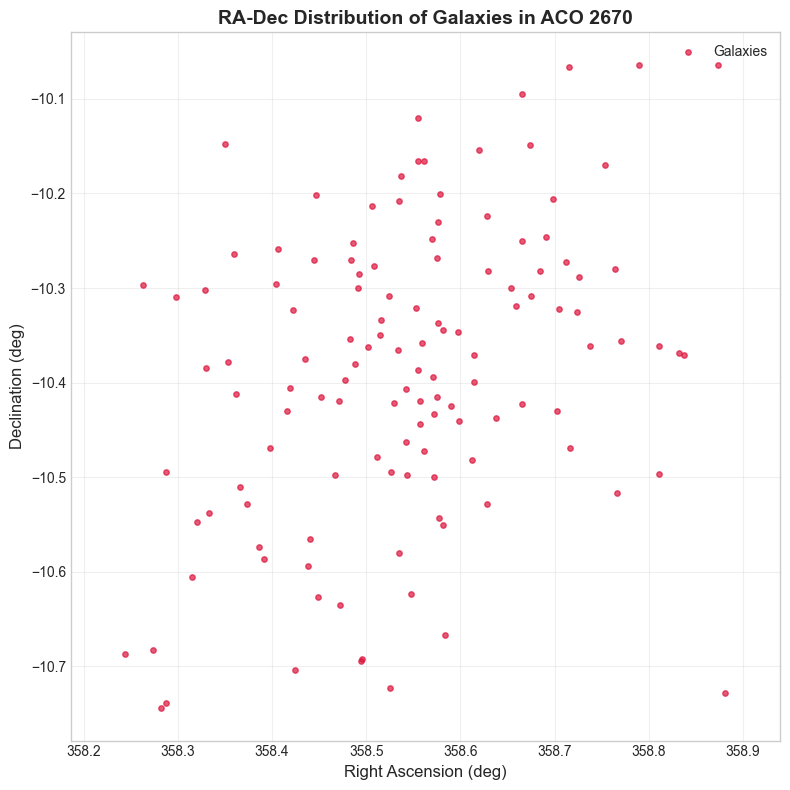

In [22]:
plot_sky_distribution(ra, dec, title="RA-Dec Distribution of Galaxies in ACO 2670")

## 6. Cluster Centroid Determination
We determine the cluster center by calculating the **weighted mean** Right Ascension and Declination. 

To maximize precision, we use **Inverse-Variance Weighting** ($w_i = 1/\sigma_i^2$), where $\sigma_i$ is the photometric error (`rErr`). This ensures that galaxies with precise measurements contribute more to the centroid calculation than those with large uncertainties.

In [23]:
weighted_ra, weighted_dec, ra_uncertainty, dec_uncertainty = compute_cluster_center(
    member_galaxies
)

print(f"Weighted Mean RA:  {weighted_ra:.4f} ± {ra_uncertainty:.4f} deg")
print(f"Weighted Mean Dec: {weighted_dec:.4f} ± {dec_uncertainty:.4f} deg")

Weighted Mean RA:  358.5492 ± 0.0003 deg
Weighted Mean Dec: -10.3909 ± 0.0003 deg


## 7. Redshift Distribution and Model Selection
To determine the cluster's dynamical state, we analyze the redshift distribution. We fit both a **Single Gaussian** (implying a relaxed cluster) and a **Gaussian Mixture Model (GMM)** (implying substructure/mergers). The best model is selected by minimizing the **Bayesian Information Criterion (BIC)**.

Best Fit Model:   Single Gaussian
Cluster Redshift: 0.076150 ± 0.003352


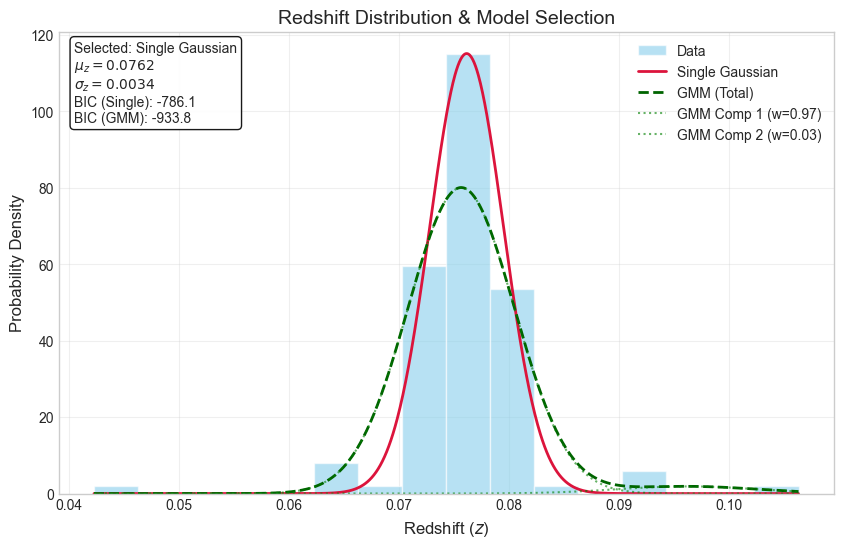

In [24]:
# Run Analysis
results = compute_redshift_distribution(member_galaxies)

# Unpack results
cluster_z, cluster_z_std, bin_edges, popt, gmm, better_model, bic_single, bic_gmm = (
    results
)

print(f"Best Fit Model:   {better_model}")
print(f"Cluster Redshift: {cluster_z:.6f} ± {cluster_z_std:.6f}")

# Visualize using the NEW function name
plot_redshift_fit(
    member_galaxies["z"].values,
    bin_edges,
    popt,
    gmm,
    better_model,
    cluster_z,
    cluster_z_std,
    bic_single,
    bic_gmm,
)

## 8. Cosmological Distance and Velocity Estimation
We convert the cluster's redshift into a **Recessional Velocity** (using the relativistic Doppler formula for $z > 0$) and a **Luminosity Distance** (using standard $\Lambda$CDM cosmology).

Uncertainties are propagated using partial derivatives, accounting for errors in both the measured redshift ($z$) and the Hubble Constant ($H_0$).

In [25]:
# Calculate distances
distance_to_cluster, distance_uncertainty, v_rec, v_rec_uncertainty = (
    compute_cluster_distance(cluster_z, cluster_z_std)
)

print(f"Recessional Velocity: {v_rec:.2f} ± {v_rec_uncertainty:.2f} km/s")
print(
    f"Luminosity Distance:  {distance_to_cluster:.2f} ± {distance_uncertainty:.2f} Mpc"
)

Recessional Velocity: 21962.31 ± 928.65 km/s
Luminosity Distance:  355.87 ± 16.66 Mpc


## 9. Spatial Structure: Projected Radial Distances
To analyze the cluster's spatial extent, we convert the angular separation of each galaxy into a physical projected distance (in Mpc).

**Note on Cosmology:** We use the **Angular Diameter Distance ($D_A$)**, not the Luminosity Distance ($D_L$), as $D_A$ is the correct metric for converting angles to transverse physical sizes at cosmological redshifts.
$$d_{proj} = \theta \cdot D_A(z_{cluster})$$

Angular Diameter Distance (Da): 307.29 Mpc


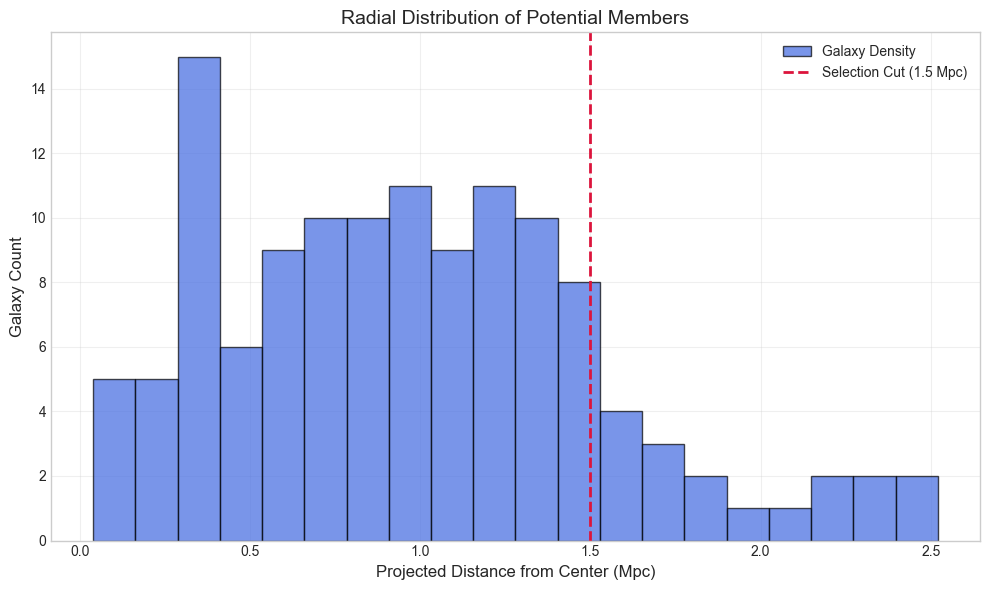

In [26]:
# 1. Calculate Angular Diameter Distance (Da) using Astropy
# Note: Da = Dl / (1+z)^2
angular_diameter_dist = COSMO.angular_diameter_distance(cluster_z).value
print(f"Angular Diameter Distance (Da): {angular_diameter_dist:.2f} Mpc")

# 2. Compute Distances
member_galaxies = compute_projected_distances(
    member_galaxies, weighted_ra, weighted_dec, angular_diameter_dist
)

# 3. Visualize
plot_radial_distribution(member_galaxies, CLUSTER_SELECTION_RADIUS_MPC)

## 10. Membership Selection
We isolate true cluster members by applying cuts in both spatial and velocity space:
1.  **Spatial Cut:** Projected physical distance $d_{proj} \le 1.5 \text{ Mpc}$.
2.  **Redshift Cut:** $|z - z_{cluster}| \le 3\sigma_z$ (removing high-velocity interlopers).

> **Visualization Note:** Due to the projection of spherical coordinates onto a 2D plane, the physical circular limit appears as an **ellipse** in the RA-Dec scatter plot. The RA axis is stretched by a factor of $1/\cos(\delta)$ relative to the Dec axis.

Selection Criteria:
  - Radius <= 1.5 Mpc
  - Redshift: 0.0661 to 0.0862 (+/- 3.0 sigma)
  - Selected 103 members from 126 candidates.


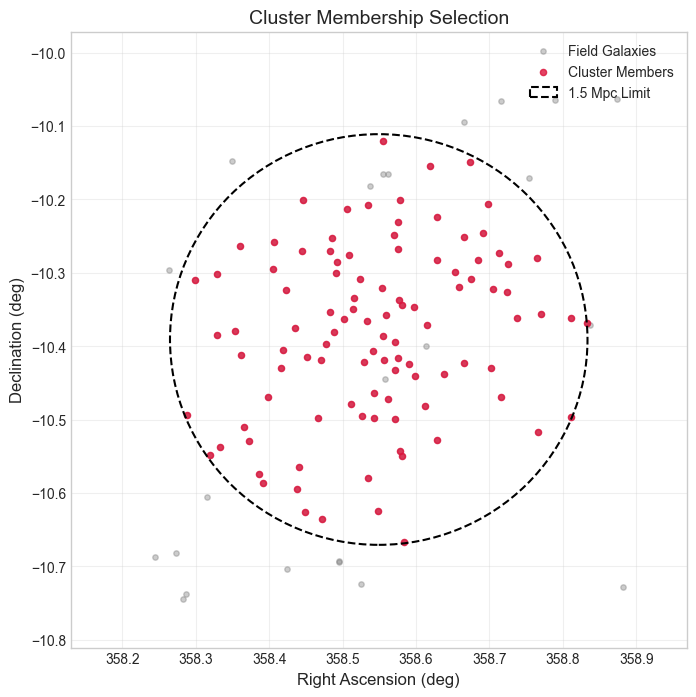

In [27]:
# 1. Apply Cuts
# Note: We update the 'member_galaxies' variable to contain ONLY members for downstream analysis
raw_galaxies = member_galaxies.copy()  # Keep a backup of full data
member_galaxies, df_with_dists = apply_membership_cuts(
    raw_galaxies,
    weighted_ra,
    weighted_dec,
    cluster_z,
    cluster_z_std,
    angular_diameter_dist,
    radius_mpc=CLUSTER_SELECTION_RADIUS_MPC,
)

# 2. Visualize
plot_member_selection(
    df_with_dists,
    member_galaxies,
    weighted_ra,
    weighted_dec,
    cluster_z,
    CLUSTER_SELECTION_RADIUS_MPC,
)

## 11. Algorithm: Iterative Membership Refinement
We apply an iterative sigma-clipping algorithm to finalize the cluster membership. In each iteration, we:
1.  Recalculate the cluster center (RA/Dec) and redshift statistics ($z, \sigma_z$).
2.  Update the angular diameter distance ($D_A$) based on the new $z$.
3.  Re-compute projected distances for all candidates.
4.  Apply the $1.5 \text{ Mpc}$ and $3\sigma_z$ cuts.

The loop terminates when the cluster properties converge (i.e., the number of members and centroid coordinates stabilize).

In [28]:
(
    final_ra,
    final_dec,
    final_ra_unc,
    final_dec_unc,
    final_z,
    final_z_std,
    final_count,
    final_members,
) = refine_cluster_properties(member_galaxies)

# Output Final Parameters
print("=" * 40)
print("FINAL CLUSTER PROPERTIES")
print("=" * 40)
print(f"Right Ascension: {final_ra:.5f} ± {final_ra_unc:.5f} deg")
print(f"Declination:     {final_dec:.5f} ± {final_dec_unc:.5f} deg")
print(f"Mean Redshift:   {final_z:.5f} ± {final_z_std:.5f}")
print(f"Member Count:    {final_count}")
print("=" * 40)

# Update the main dataframe variable to point to the refined set
member_galaxies = final_members

--- Iteration 1 ---
  Centroid: (358.5504, -10.3817)
  Redshift: 0.07656 ± 0.00300
  Members:  98
--- Iteration 2 ---
  Centroid: (358.5546, -10.3768)
  Redshift: 0.07642 ± 0.00346
  Members:  98
--- Iteration 3 ---
  Centroid: (358.5546, -10.3768)
  Redshift: 0.07642 ± 0.00346
  Members:  98
Convergence reached in 3 iterations.

FINAL CLUSTER PROPERTIES
Right Ascension: 358.55460 ± 0.00029 deg
Declination:     -10.37682 ± 0.00026 deg
Mean Redshift:   0.07642 ± 0.00346
Member Count:    98


## 12. Final Cluster Verification
We visualize the spatial and kinematic structure of the **final refined member list**.
* **Spatial Plot:** Confirms that the iterative centroiding converged on a dense core.
* **Redshift Plot:** Confirms that the final velocity distribution is well-described by a Gaussian (virialized state) without significant outliers.

[INFO] Successfully loaded 126 galaxy records.


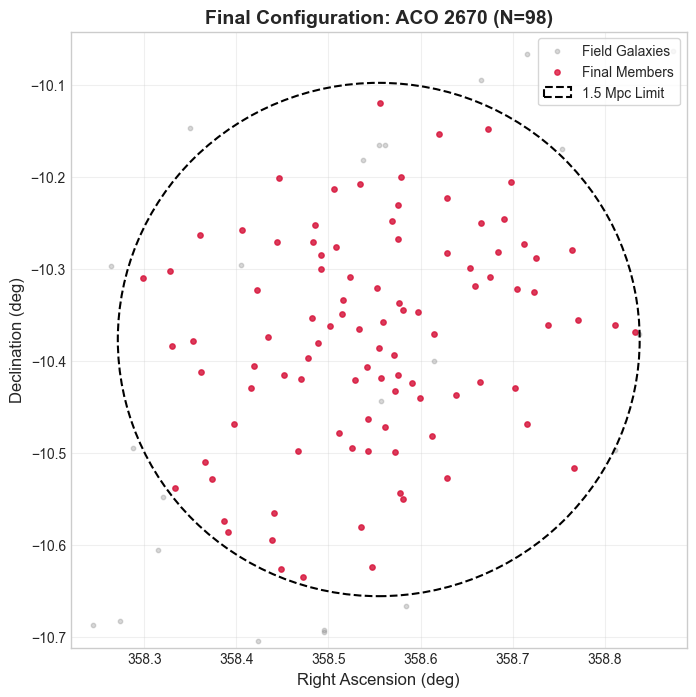


--- Final Redshift Statistics (N=98) ---


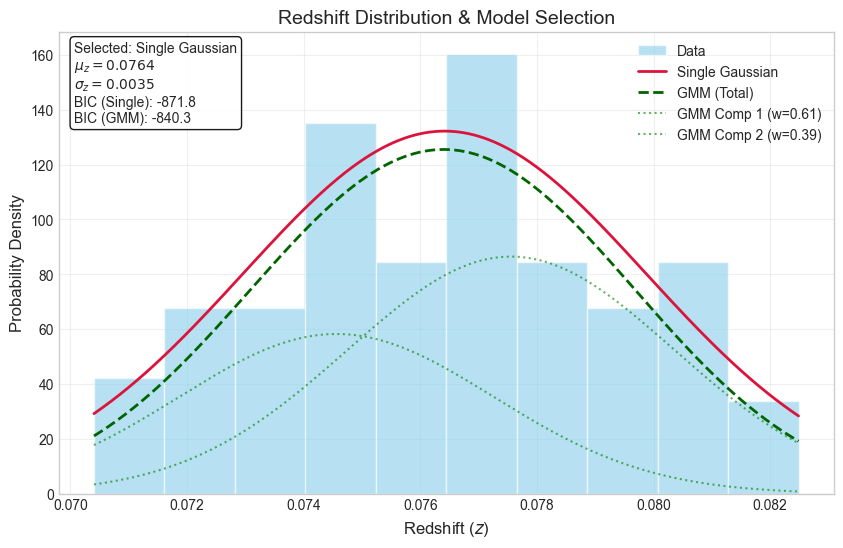

In [29]:
# 1. Reload full dataset for background context
full_dataset = load_galaxy_data("data/cluster_data.csv")

# 2. Plot
plot_final_spatial_distribution(
    full_dataset,
    member_galaxies,  # This contains only the FINAL members now
    final_ra,
    final_dec,
    final_z,
    CLUSTER_SELECTION_RADIUS_MPC,
)

# -----------------------------------------------------------------------------
# Final Redshift Distribution
# -----------------------------------------------------------------------------
print(f"\n--- Final Redshift Statistics (N={len(member_galaxies)}) ---")

# Re-run Gaussian/GMM fit on the CLEANED member list
z_results = compute_redshift_distribution(member_galaxies)

(
    final_cluster_z,
    final_cluster_sigma,
    z_bins,
    z_popt,
    z_gmm,
    z_model_name,
    z_bic_s,
    z_bic_g,
) = z_results

# Visualize
plot_redshift_fit(
    member_galaxies["z"].values,
    z_bins,
    z_popt,
    z_gmm,
    z_model_name,
    final_cluster_z,
    final_cluster_sigma,
    z_bic_s,
    z_bic_g,
)

## 13. Photometric Analysis: Absolute Magnitudes
We calculate the absolute $r$-band magnitude ($M_r$) for each member galaxy using the distance modulus formula:
$$M_r = m_r - A_r - 5 \log_{10}(D_L) + 5$$
where $m_r$ is the apparent magnitude, $A_r$ is the extinction correction, and $D_L$ is the luminosity distance in parsecs. 

Uncertainties are propagated from photometric errors ($\sigma_m$) and distance uncertainties ($\sigma_{D_L}$).

Final Luminosity Distance: 357.18 ± 17.18 Mpc
Brightest Galaxy (BCG): -23.5789
Faintest Galaxy:        -20.0447


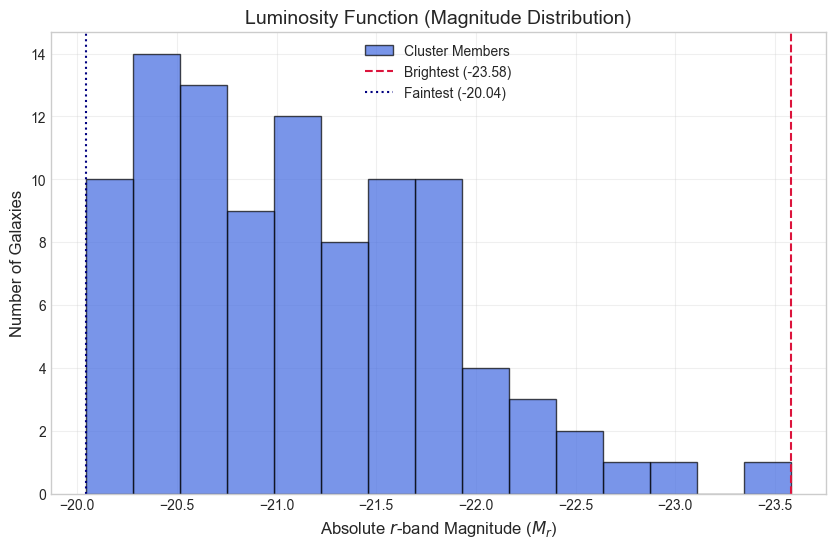

In [30]:
# 1. Recalculate Luminosity Distance for the FINAL cluster redshift
final_dl, final_dl_err, _, _ = compute_cluster_distance(final_z, final_z_std)

print(f"Final Luminosity Distance: {final_dl:.2f} ± {final_dl_err:.2f} Mpc")

# 2. Compute Magnitudes
member_galaxies = compute_absolute_magnitudes(member_galaxies, final_dl, final_dl_err)

# 3. Display Stats
print(f"Brightest Galaxy (BCG): {member_galaxies['M_r'].min():.4f}")
print(f"Faintest Galaxy:        {member_galaxies['M_r'].max():.4f}")

# 4. Visualize
plot_magnitude_distribution(member_galaxies)

## 14. Physical Properties: Galaxy Luminosities
We convert absolute magnitudes ($M_r$) to solar luminosities ($L_{\odot}$) to facilitate mass-to-light ratio calculations.
$$L_r = 10^{0.4(M_{\odot, r} - M_r)}$$
where $M_{\odot, r} = 4.76$ is the absolute magnitude of the Sun in the SDSS $r$-band.

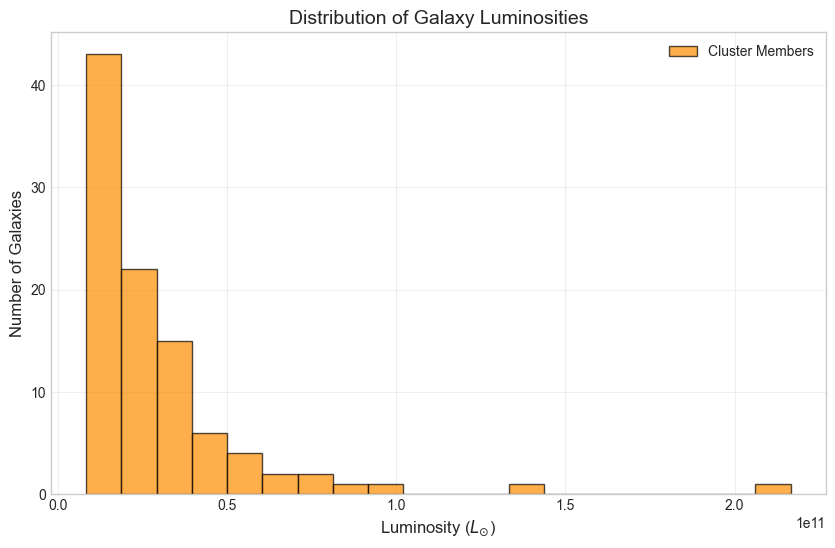

Top 5 Brightest Galaxies (L_sun):


,ra,dec,M_r,L_r
23,358.556929,-10.419022,-23.578895,2.165500e+11
24,358.725707,-10.288067,-23.091849,1.382737e+11
51,358.418834,-10.405536,-22.673260,9.403817e+10
74,358.444457,-10.270801,-22.633342,9.064350e+10
36,358.448318,-10.626110,-22.457604,7.709773e+10


In [31]:
# 1. Compute
member_galaxies = compute_luminosities(member_galaxies)

# 2. Visualize
plot_luminosity_distribution(member_galaxies)

# 3. Inspect Top 5 Brightest
print("Top 5 Brightest Galaxies (L_sun):")
display(
    member_galaxies[["ra", "dec", "M_r", "L_r"]]
    .sort_values("L_r", ascending=False)
    .head()
)

## 15. Structural Analysis: Luminosity Profile & Effective Radius
We construct the **Cumulative Luminosity Profile** $L(<r)$ to determine the concentration of light. 
1.  **Effective Radius ($R_{eff}$):** The projected radius containing 50% of the total cluster luminosity.
2.  **Half-Mass Radius ($r_{1/2}$):** The deprojected 3D radius, estimated as $r_{1/2} \approx \frac{4}{3} R_{eff}$ (assuming spherical symmetry).

Total Cluster Luminosity (L_1.5): 2.859e+12 ± 3.980e+10 L_sun
Effective Radius (R_eff):    0.799 ± 0.006 Mpc
Half-Mass Radius (r_1/2):    1.066 ± 0.009 Mpc


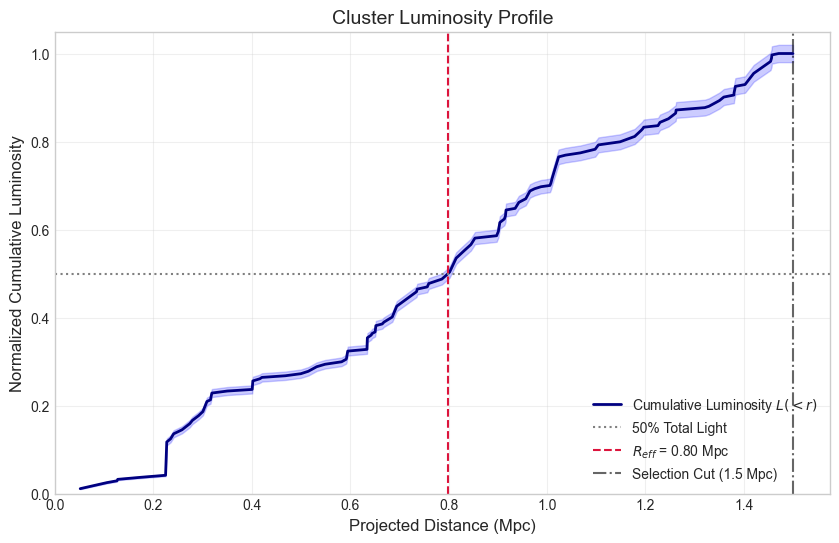

In [32]:
# 1. Compute Profile
(
    radial_distances,
    normalized_cdf,
    normalized_err,
    total_luminosity,
    total_luminosity_err,
) = compute_cumulative_luminosity(member_galaxies)

print(
    f"Total Cluster Luminosity (L_1.5): {total_luminosity:.3e} ± {total_luminosity_err:.3e} L_sun"
)

# 2. Calculate Structural Parameters
R_eff, r_half, R_eff_err, r_half_err = compute_effective_radius(
    radial_distances, normalized_cdf, normalized_err
)

print(f"Effective Radius (R_eff):    {R_eff:.3f} ± {R_eff_err:.3f} Mpc")
print(f"Half-Mass Radius (r_1/2):    {r_half:.3f} ± {r_half_err:.3f} Mpc")

# 3. Visualize
plot_cumulative_profile(radial_distances, normalized_cdf, normalized_err, R_eff)

## 16. Kinematic Analysis: Dynamics and Mass Proxies
We derive the dynamical properties of the cluster to estimate its mass.
1.  **Peculiar Velocities:** We calculate the rest-frame velocity of each galaxy relative to the cluster center.
    $$v_{pec} = \frac{v_{los} - v_{cluster}}{1 + z_{cluster}}$$
2.  **Velocity Dispersion ($\sigma_v$):** We estimate the line-of-sight velocity dispersion using two methods:
    * **Gaussian Fit:** Maximum Likelihood Estimation.
    * **Biweight Midvariance:** A robust estimator insensitive to outliers (Beers et al. 1990).

Velocity Dispersion (Gaussian): 931.59 ± 94.80 km/s
Velocity Dispersion (Biweight): 788.81 km/s
Substructure Check (Multimodality): Not Detected


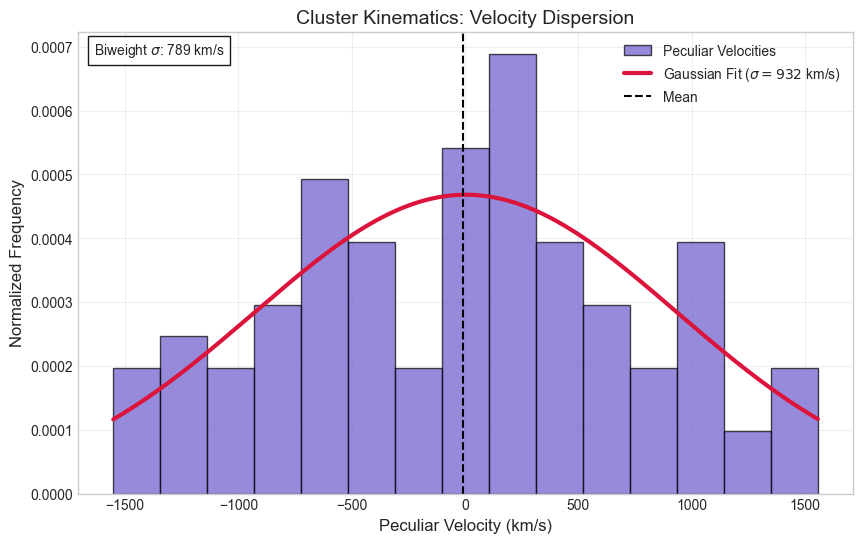

In [33]:
# 1. Calculate Velocities
member_galaxies = compute_peculiar_velocities(member_galaxies, final_z, final_z_std)

# 2. Measure Dispersion
v_pec = member_galaxies["v_pec"].values
sigma_v, sigma_v_err, sigma_bi, v_popt = measure_velocity_dispersion(v_pec)

# 3. Display Results
print(f"Velocity Dispersion (Gaussian): {sigma_v:.2f} ± {sigma_v_err:.2f} km/s")
print(f"Velocity Dispersion (Biweight): {sigma_bi:.2f} km/s")

# 4. Check for Substructure
is_bimodal = test_multimodality(v_pec)
print(
    f"Substructure Check (Multimodality): {'Likely' if is_bimodal else 'Not Detected'}"
)

# 5. Visualize
plot_velocity_dispersion(v_pec, v_popt, sigma_v, sigma_bi)

## 17. Mass Estimation and Dark Matter Content
We compute the final cluster properties using the **Virial Theorem**.
1.  **Virial Mass ($M_{1/2}$):** The mass contained within $r_{1/2}$, assuming dynamic equilibrium.
    $$M_{1/2} \approx \frac{3 \sigma_v^2 r_{1/2}}{G}$$
2.  **Mass-to-Light Ratio ($M/L$):** The ratio of total gravitating mass to total luminosity. High values ($> 100 M_{\odot}/L_{\odot}$) indicate Dark Matter dominance.

In [34]:
# -----------------------------------------------------------------------------
# 1. Calculate Virial Mass
# -----------------------------------------------------------------------------
# Uses 'sigma_v' (Gaussian dispersion) and 'r_half' (Half-mass radius)
M_virial, M_virial_err = compute_virial_mass(sigma_v, sigma_v_err, r_half, r_half_err)

# -----------------------------------------------------------------------------
# 2. Calculate Enclosed Luminosity (L_1/2)
# -----------------------------------------------------------------------------
# We re-interpolate the CDF because r_half is a derived value not in the original array
cdf_interpolator = interp1d(radial_distances, normalized_cdf, kind="linear")

# Fraction of total light enclosed within r_half
flux_fraction_half = float(cdf_interpolator(r_half))
L_half = total_luminosity * flux_fraction_half

# Approximate error (dominated by total luminosity error)
L_half_err = total_luminosity_err * flux_fraction_half

# -----------------------------------------------------------------------------
# 3. Calculate Mass-to-Light Ratio
# -----------------------------------------------------------------------------
ml_ratio, ml_ratio_err = compute_mass_to_light(
    M_virial, M_virial_err, L_half, L_half_err
)

# -----------------------------------------------------------------------------
# 4. Calculate Final Recessional Velocity
# -----------------------------------------------------------------------------
# Uses the refined redshift from Step 10
_, _, final_v_rec, final_v_rec_err = compute_cluster_distance(final_z, final_z_std)

# -----------------------------------------------------------------------------
# 5. Final Report
# -----------------------------------------------------------------------------
print("\n" + "=" * 50)
print("FINAL CLUSTER PARAMETERS (ACO 2670)")
print("=" * 50)
print(f"Mean Redshift:       {final_z:.5f} ± {final_z_std:.5f}")
print(f"Recessional Vel:     {final_v_rec:.0f} ± {final_v_rec_err:.0f} km/s")
print(f"Velocity Dispersion: {sigma_v:.0f} ± {sigma_v_err:.0f} km/s")
print("-" * 50)
print(f"Effective Radius:    {R_eff:.3f} ± {R_eff_err:.3f} Mpc")
print(f"Half-Mass Radius:    {r_half:.3f} ± {r_half_err:.3f} Mpc")
print("-" * 50)
print(f"Virial Mass (M_1/2): {M_virial:.2e} ± {M_virial_err:.2e} M_sun")
print(f"Enclosed Light:      {L_half:.2e} ± {L_half_err:.2e} L_sun")
print("-" * 50)
print(f"Mass-to-Light Ratio: {ml_ratio:.0f} ± {ml_ratio_err:.0f} (M_sun/L_sun)")
print("=" * 50)


FINAL CLUSTER PARAMETERS (ACO 2670)
Mean Redshift:       0.07642 ± 0.00346
Recessional Vel:     22036 ± 958 km/s
Velocity Dispersion: 932 ± 95 km/s
--------------------------------------------------
Effective Radius:    0.799 ± 0.006 Mpc
Half-Mass Radius:    1.066 ± 0.009 Mpc
--------------------------------------------------
Virial Mass (M_1/2): 6.45e+14 ± 1.31e+14 M_sun
Enclosed Light:      2.21e+12 ± 3.08e+10 L_sun
--------------------------------------------------
Mass-to-Light Ratio: 292 ± 60 (M_sun/L_sun)
